In [2]:
!pip install causalml

Defaulting to user installation because normal site-packages is not writeable
Processing /home/ns4486/.cache/pip/wheels/d7/16/cd/f9918ec891368bfcbbd4f6de9a612dfbe2b9d9c64e24c729a8/causalml-0.10.0-cp38-cp38-linux_x86_64.whl
  Using cached pyro_ppl-1.6.0-py3-none-any.whl (634 kB)
  Using cached pyro_api-0.1.2-py3-none-any.whl (11 kB)


ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: pytorch-lightning 0.9.0 has requirement tensorboard==2.2.0, but you'll have tensorboard 2.5.0 which is incompatible.
ERROR: pyro-ppl 1.6.0 has requirement torch>=1.8.0, but you'll have torch 1.5.0+cu101 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import causalml

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

In [2]:
import os, sys
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

pd.set_option('display.max_columns', None)


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.explore_utils as eu

In [3]:
type_map = {
    'decision_date' : 'str',
    'filing_date' : 'str',
    'Court Name' : 'category',
    'Party of Appointing President' : 'category',
    'CIRCUIT' : 'category',
    'JURIS' : 'category',
    'NOS' : 'category',
    'ORIGIN' : 'category',
    'RESIDENC' : 'category',
    'CLASSACT' : 'category',
    'DEMANDED' : 'float64',
    'TERMDATE' : 'str',
    'DISP' : 'category',
    'PROCPROG' : 'category',
    'NOJ' : 'category',
    'AMTREC' : 'category',
    'JUDGMENT' : 'category',
    'TAPEYEAR' : 'float64',
    'district' : 'category',
    'office' : 'category',
    'county' : 'category',
    'TRCLACT' : 'category',
    'PROSE' : 'category',
    'arbit' : 'category',
    'transoff' : 'category',
    'trmarb' : 'category',
    'ifp' : 'category',
    'statuscd' : 'category'
}

cols_to_drop = [
    'decision_date',
#     'filing_date',
    'TERMDATE',
    'TAPEYEAR'
]

df = pd.read_csv(
    '/scratch/ayl316/ttml_mr_data/processed_data/cases.csv.zip', 
    dtype = type_map, 
    parse_dates = ['decision_date', 'filing_date', 'TERMDATE']
).rename(columns = {
    'Court Name' : 'court_name',
    'Party of Appointing President' : 'party'
}).drop(columns = cols_to_drop)


df['filing_year'] = pd.DatetimeIndex(df['filing_date']).year
df['filing_year'] = df['filing_year'].astype(str).astype('category')
df = df.drop(columns = ['filing_date'])

for col in ['party', 'TRCLACT', 'PROSE', 'arbit', 'transoff', 'trmarb', 'ifp', 'statuscd', 'filing_year']:
    if not '-8' in df[col].cat.categories:
        df[col] = df[col].cat.add_categories('-8')
    df[col] = df[col].fillna('-8')

df['district_year'] = df['district'].astype(str) + '_' + df['filing_year'].astype(str)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219459 entries, 0 to 1219458
Data columns (total 26 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   court_name     1219459 non-null  category
 1   party          1219459 non-null  category
 2   CIRCUIT        1219459 non-null  category
 3   JURIS          1219459 non-null  category
 4   NOS            1219459 non-null  category
 5   ORIGIN         1219459 non-null  category
 6   RESIDENC       1219459 non-null  category
 7   CLASSACT       1219459 non-null  category
 8   DEMANDED       1219459 non-null  float64 
 9   DISP           1219459 non-null  category
 10  PROCPROG       1219459 non-null  category
 11  NOJ            1219459 non-null  category
 12  AMTREC         1219459 non-null  category
 13  JUDGMENT       1219459 non-null  category
 14  district       1219459 non-null  category
 15  office         1219459 non-null  category
 16  county         1219459 non-null  cat

In [5]:
feature_cols = [
#     'NOJ',
#     'JUDGMENT',
#     'PROSE',
#     'trmarb',
    'CLASSACT',
    'JURIS',
#     'TRCLACT',
#     'ifp', (too many nulls)
#     'statuscd',
#     'PROCPROG',
#     'CIRCUIT',
#     'transoff',
    'ORIGIN',
#     'arbit', (too many nulls)
    'office',
#     'court_name',
    'NOS',
    'district',
#     'TAPEYEAR',
    'RESIDENC',
#     'DISP',
    'filing_year',
    'district_year'
]

treatment_col = 'party'
response_col = 'JUDGMENT'

# eu.cat_heat_map(df, feature_cols)

In [6]:
df[feature_cols]

,CLASSACT,JURIS,ORIGIN,office,NOS,district,RESIDENC,filing_year,district_year
0,-8.0,2.0,1.0,8,510.0,16,-8.0,2016.0,16_2016.0
1,-8.0,2.0,1.0,8,510.0,16,-8.0,2016.0,16_2016.0
2,-8.0,2.0,1.0,8,510.0,16,-8.0,2016.0,16_2016.0
3,-8.0,2.0,1.0,8,510.0,16,-8.0,2016.0,16_2016.0
4,-8.0,2.0,1.0,8,510.0,16,-8.0,2016.0,16_2016.0
...,...,...,...,...,...,...,...,...,...
1219454,-8.0,4.0,2.0,4,110.0,65,15.0,2016.0,65_2016.0
1219455,-8.0,4.0,2.0,4,110.0,65,15.0,2016.0,65_2016.0
1219456,-8.0,3.0,1.0,2,442.0,15,-8.0,2015.0,15_2015.0
1219457,-8.0,3.0,1.0,2,442.0,15,-8.0,2015.0,15_2015.0


In [7]:
df = df[(df[treatment_col] == 'Republican') | (df[treatment_col] == 'Democratic')]

df = df[(df[response_col] == '1.0') | (df[response_col] == '2.0')]

for col in feature_cols:
    if df[col].dtype.name == 'category':
        df[col] = df[col].cat.remove_unused_categories()

X = df[feature_cols]
treatment = df[treatment_col]
y = df[response_col].astype(float)

treatment = treatment.cat.add_categories(['1', '0'])
treatment[treatment == 'Democratic'] = '1'
treatment[treatment == 'Republican'] = '0'
treatment = treatment.cat.remove_unused_categories()
treatment = treatment.astype(float)
treatment = treatment.reset_index(drop = True)

y[y != 1] = -1
y = y.reset_index(drop = True)

In [8]:
enc = OneHotEncoder(drop = 'first')
enc.fit(X)
X_ohe = enc.transform(X).toarray()

# scaler = StandardScaler().fit(X_ohe)
# X_scaled = pd.DataFrame(
#     scaler.transform(X_ohe),
#     columns = enc.get_feature_names(feature_cols)
# )

cols_X = enc.get_feature_names(feature_cols)

X_scaled = pd.DataFrame(
    X_ohe,
    columns = cols_X
)

X_scaled = sm.add_constant(X_scaled)

df_proc = X_scaled
df_proc['y'] = y
df_proc['treatment'] = treatment

In [9]:
# df_sample = df_proc.sample(n = 10000)
# X_ = df_sample[cols_X]
# y_ = df_sample['y']
# treatment_ = df_sample['treatment']

X = df_proc[cols_X]
y = df_proc['y']
treatment = df_proc['treatment']

In [10]:
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))


# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)


# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

(array([0.01427895]), array([0.01034225]), array([0.01821566]))
ATE estimate: 0.014
ATE lower bound: 0.010
ATE upper bound: 0.018
Using the ready-to-use XGBTRegressor class
(array([0.02101356]), array([0.01770417]), array([0.02432295]))

Using the BaseTRegressor class and using XGB (same result):
(array([0.02101356]), array([0.01770417]), array([0.02432295]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([-23682848.75071696]), array([-70184910.40381919]), array([22819212.90238528]))


CATE-S :  [[0.01427895]
 [0.01427895]
 [0.01427895]
 ...
 [0.01427895]
 [0.01427895]
 [0.01427895]]
CATE-T :  [[-0.16968064]
 [-0.16968064]
 [-0.16968064]
 ...
 [ 0.0227778 ]
 [ 0.0227778 ]
 [ 0.0227778 ]]
CATE-X-nop :  [[0.05676988]
 [0.05676988]
 [0.05676988]
 ...
 [0.01631163]
 [0.01631163]
 [0.01631163]]
CATE-R-nop :  [[0.13767061]
 [0.13767061]
 [0.13767061]
 ...
 [0.00843058]
 [0.00843058]
 [0.00843058]]


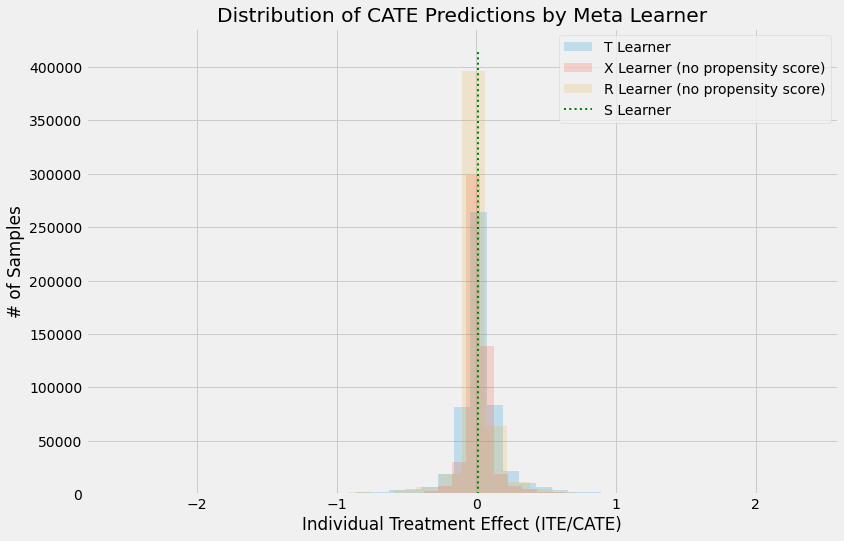

<Figure size 432x288 with 0 Axes>

In [11]:

# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)
print('CATE-S : ', cate_s)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)
print('CATE-T : ', cate_t)

# X Learner with propensity score input
#     learner_x = BaseXRegressor(learner=XGBRegressor())
#     cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)
print('CATE-X-nop : ', cate_x_no_p)

# R Learner with propensity score input 
#     learner_r = BaseRRegressor(learner=XGBRegressor())
#     cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)
print('CATE-R-nop : ', cate_r_no_p)

alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
#     plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
#     plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()
plt.show()

plt.savefig('/scratch/ns4486/cate_plot.png')